In [1]:
# this function was exported to allow multiprocessing.
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt


plt.style.use('seaborn-v0_8-paper')

from itertools import chain

sys.path.append('../utils')
import data_paths
from traffic_counts import TrafficCounts
from hbefa_hot_emissions import HbefaHotEmissions

# Import Data
- VISUM link data (cut to Munich Boarders)
- Initilize counting data object
- Initialize HBEFA emission calculator object

In [2]:
# import data
# import visum model
visum_links = gpd.read_file(data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg')
boarders = gpd.read_file(data_paths.MUNICH_BOARDERS_FILE).to_crs(25832)
visum = gpd.clip(visum_links, boarders)
visum = visum.explode(ignore_index=True) # convert multipolygons to polygons

visum = visum.reset_index(drop = True).reset_index() # reset index for calculation
visum['road_lenght'] = visum['geometry'].length # add road length to visum dict

# initialize traffic cycles
cycles = TrafficCounts()
# initialize HBEFA emission factors
hbefa = HbefaHotEmissions()

Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_PC.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_LCV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_HGV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_Coach.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_MOT.XLS


# Notebook Function

In [3]:
def process_veh_kilometers (date: str,
                            visum_dict:dict,
                            cycles_obj:TrafficCounts,
                            hbefa_obj:HbefaHotEmissions,
                            ) -> bool:
    """Function to calculate daily emissions for a given date. 
    This implements the HbefaHotEmissions object and can be run as parallell processes.

    Args:
        date (str): day to be calculated
        visum_dict (dict): traffic model as dict for faster looping
        cycles_obj (TrafficCounts): object to access traffic cycles
        hbefa_obj (HbefaHotEmissions): object to access emission factors
    Returns:
        bool: true if process finished without error, false if not.
    """
    # get scaling factors for the day
    diurnal_cycles = cycles_obj.get_hourly_scaling_factors(date=date)
    vehicle_shares = cycles_obj.get_vehicle_share(date=date).to_dict()
    daily_scaling = cycles_obj.get_daily_scaling_factors(date=date).to_dict()
    
    result = list()
    
    final_result = {'Freeflow': np.array(5, float),
                    'Heavy': np.array(5, float),
                    'Satur.': np.array(5, float),
                    'St+Go': np.array(5, float)}
    
    # loop over visum model
    for row in visum_dict:
        
        # relevant information from the visum model
        dtv_visum = row['dtv_SUM']
        hgv_corr = row['hgv_corr']
        lcv_corr = row['lcv_corr']
        scaling_road_type = row['scaling_road_type']
        
        # get vehicle shares from counting data
        hgv_share = vehicle_shares['HGV'][scaling_road_type]
        lcv_share = vehicle_shares['LCV'][scaling_road_type]
        pc_share = vehicle_shares['PC'][scaling_road_type]
        mot_share = vehicle_shares['MOT'][scaling_road_type]
        bus_share = vehicle_shares['BUS'][scaling_road_type]
        
        # calculate vehicle share correction factor
        k = (1- (hgv_corr * hgv_share)- (lcv_corr * lcv_share)) / (1 - hgv_share - lcv_share)
        
        # calculate vehicle counts and apply vehicle share correction factor
        dtv = dict()
        dtv_day = dtv_visum * daily_scaling[scaling_road_type]
        dtv.update({'HGV' : (dtv_day * hgv_share * hgv_corr)})
        dtv.update({'LCV' : (dtv_day * lcv_share * lcv_corr)})
        dtv.update({'PC' : (dtv_day * pc_share * k)})
        dtv.update({'MOT' : (dtv_day * mot_share * k)})
        dtv.update({'BUS' : (dtv_day * bus_share * k)})
        
        dtv_array = np.array([dtv[v] for v in diurnal_cycles.index])
        htv = (np.transpose(diurnal_cycles.to_numpy()) * dtv_array)
        
        # calculate total hourly traffic count as passenger car equivalents
        htv_car_units = np.array([HbefaHotEmissions.car_unit_factors[v]\
            for v in diurnal_cycles.index])
        htv_car_units = (htv * htv_car_units).sum(axis=1)
        
        
        # list of 24 service classes for each hour of the day
        los_class = [hbefa_obj.calc_los_class(htv_car_unit = x,
                                                hour_capacity = row['hour_capacity'],
                                                road_type = row['road_type'],
                                                hbefa_speed = row['hbefa_speed'])
                        for x in htv_car_units]
        
        los =  [x.split('/')[-1] for x in los_class]

        # now calculate vehicle kilometers
        veh_kilometers  = htv * row['road_lenght'] *1e-3
        #comb = zip(los, veh_kilometers)
        
        result.append(list(zip(los, veh_kilometers)))
     
    for e in list(chain(*result)):
        final_result[e[0]] = final_result[e[0]] + e[1]

    return final_result, diurnal_cycles.index
        


# Data processing

In [4]:
vkt_result = dict()
for year in ['2019', '2020', '2021', '2022']:
    
    # generate dates index
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    dates = [d.strftime("%Y-%m-%d") for d in pd.date_range(start=start_date, end=end_date, freq='1d')]

    final_result = {'Freeflow': np.array(5, float),
                    'Heavy': np.array(5, float),
                    'Satur.': np.array(5, float),
                    'St+Go': np.array(5, float)}
    for date in dates: 
        cl, vehicle_index = process_veh_kilometers(date= date,
                            visum_dict=visum.to_dict('records'),
                            cycles_obj = cycles,
                            hbefa_obj = hbefa)
        
        for key, value in cl.items():
            final_result[key] = final_result[key] + value
    vkt_result.update({year:final_result})

In [9]:
# calculate total vehicle kilometers by vehicle class
total_vkt = pd.DataFrame()
for key, item in vkt_result.items(): 
    df = pd.DataFrame(data = item, index = vehicle_index).sum(axis =1)
    df.name = key
    total_vkt = pd.concat([total_vkt, df], axis = 1)

total_vkt = total_vkt.transpose()
total_vkt = total_vkt[['PC', 'LCV', 'HGV', 'BUS', 'MOT']]
total_vkt

,PC,LCV,HGV,BUS,MOT
2019,4.943327e+09,8.358113e+08,2.749687e+08,3.597810e+07,5.756243e+07
2020,4.217210e+09,8.035521e+08,2.563890e+08,3.583094e+07,5.669105e+07
2021,4.259646e+09,8.466288e+08,2.586513e+08,3.616866e+07,5.011544e+07
2022,4.422801e+09,8.720375e+08,2.513671e+08,3.715454e+07,5.715648e+07


In [10]:
# calculate LOS share or total kilometers
los_class_vkt = pd.DataFrame()
for key, item in vkt_result.items(): 
    df = pd.DataFrame(data=item, index = vehicle_index).sum(axis = 0)
    df.name = key
    los_class_vkt = pd.concat([los_class_vkt, df], axis = 1)

los_class_vkt = los_class_vkt.transpose()

los_class_vkt = los_class_vkt.divide(los_class_vkt.sum(axis=1), axis =0)
los_class_vkt

,Freeflow,Heavy,Satur.,St+Go
2019,0.653608,0.268686,0.046435,0.031271
2020,0.693895,0.255877,0.036119,0.014110
2021,0.684948,0.264220,0.036042,0.014790
2022,0.686128,0.267606,0.031594,0.014673


# Plotting

/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_68258/1019816967.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = y_labels, fontsize= 10)


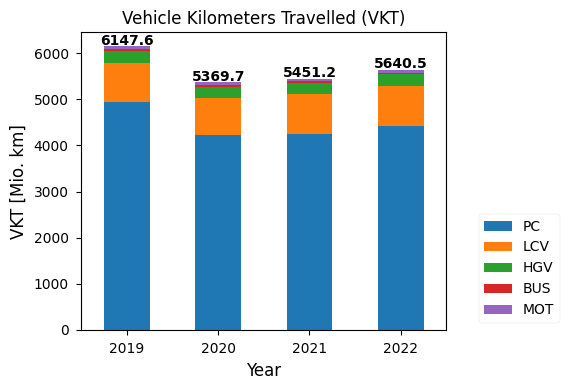

In [18]:
fig, ax = plt.subplots(figsize =(6,4), tight_layout =True)

total_vkt.plot(ax = ax, kind='bar', stacked = True)

plt.title('Vehicle Kilometers Travelled (VKT)', fontsize = 12)

# add totals
y_offset = 3*1e7
for idx, year in enumerate(total_vkt.index):
    annual_vkt = total_vkt.loc[year].sum()
    ax.text(y = annual_vkt + y_offset,
            x= idx,
            s = f'{(annual_vkt*1e-6):.1f}',
            fontsize =10,
            weight='bold', 
            ha = 'center')

y_labels = ax.get_yticks()
y_labels = [f'{int(label)*1e-6:.0f}' for label in y_labels]
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=0, fontsize = 10)
ax.set_yticklabels(labels = y_labels, fontsize= 10)
ax.set_ylabel('VKT [Mio. km]', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)

plt.legend(bbox_to_anchor =(1.2,0), loc = 'lower center', ncols=1, fontsize = 10)
plt.show()

/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_68258/1948940268.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = y_labels, fontsize= 10)


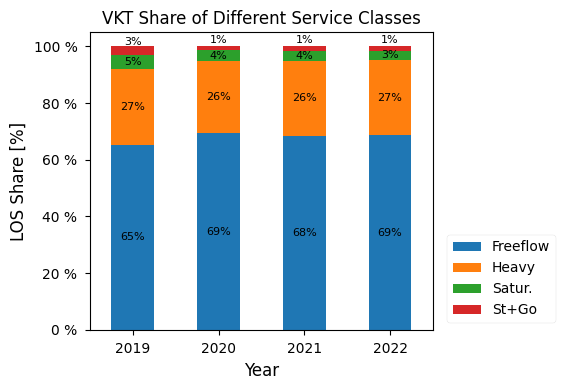

In [17]:
fig, ax = plt.subplots(figsize =(6,4), tight_layout =True)

los_class_vkt.plot(ax = ax, kind='bar', stacked = True)

plt.title('VKT Share of Different Service Classes', fontsize = 12)


y_labels = ax.get_yticks()
y_labels = [f'{label*1e2:.0f} %' for label in y_labels]
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=0, fontsize = 10)
ax.set_yticklabels(labels = y_labels, fontsize= 10)
ax.set_ylabel('LOS Share [%]', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)

iterator = 0
for idx, row in los_class_vkt.iterrows():
    pos_y = 0
    for el in row:
        ax.text(y = pos_y +(el/2),
            x= iterator,
            s = f'{el*100:.0f}%',
            fontsize =8,
            ha = 'center',
            va = 'center', color = 'black')
        if (el)<0.05: 
            pos_y += (el + 0.03)
        else: 
            pos_y += el
    iterator+=1

plt.legend(bbox_to_anchor =(1.2,0), loc = 'lower center', ncols=1, fontsize = 10)
plt.show()